# Somaye Farhadi

Assignment Explanation:

_Attached to this email is a Tiff file of some simplified imagery data. Every pixel denoted with a 1 represents vegetation and is part of a plant (all other pixels are considered to be non-vegetation). The task is to create "plant objects," which means to find all pixels that belong to one particular plant and group them together. Please complete this assignment using Python and provide a documented script (.py or .ipynb file) explaining your method. Also, please do not feel the need to spend more than 2 hours on this task. There is no particular right answer or method for this assignment. How you present these "plant objects" is up to you. The goal is to see how you approach the problem._

__In the following, I have used OpenCV library for image analysis. Particularly, I have used its function "cv2.connectedComponents" to find the connected regions of space (which presumably assigns one plant to each connected region). I can alternatively write a code from scratch to find the connected regions based on (for example) two-pass algorithm. However, since OpenCV does this efficiently, I just used the package!__

In [1]:
# importing all libraries used in this assignment. I have used OpenCV for doing basic image processing.
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Change the following line to the folder location where the .tif file is stored
drct = '/home/somayeh/Documents/Ramboll_assignment/data_for_assignment/'
name = 'data_for_assignment.tif'
##################################################
# Reading the image file to variable "img"
img = cv2.imread(drct+name, 0)

The following class is defined to contained all the method needed to find and characterize plants:

In [3]:
# The class "plant_object" is defined to incorporate methods for representing plants in the image. 

class plant_object:
    
    def __init__(self, img):
        self.img = img
    
    #plant_finder is the method to find clusters of vegetation, assuming that each cluster represents unique plant. 
    #This assumption is subject to debate. Maybe one cluster contains more than one single plant.
    #However, with having only "ones" in the image array, this is a reasonable assumption we can make.
    def plant_finder(self):
        ret,labels = cv2.connectedComponents(self.img)
        return labels
    
    # plant_area method returns the area associated with plant i in number of pixels it spans.
    def plant_area(self, i):
        number_of_pixels_i = np.count_nonzero(self.plant_finder() == i)
        return number_of_pixels_i
    
    #plant_location returns an 2D numpy array of all pixels that a certain plant, i, spans. (first/second row is y/x axis)
    def plant_location(self, i):
        location_array = np.where(self.plant_finder() == i)
        return location_array
    
    #plant_show highlights a specific plant, i, in the image
    def plant_show(self, i):
        plt.imshow(img)
        x = self.plant_location(i)[1] ; y = self.plant_location(i)[0]
        plt.plot(x,y,'g')
        plt.show()
           

Now we can create an object "plants" using class "plant_object" we just defined:

In [4]:
# define object plants
plants = plant_object(img)

__In the next step, I provide some examples on simple analysis and visualization using plants object__

In [5]:
# First let's see how many plants we have in the image:
Num = np.amax(plants.plant_finder())
print("There are",Num-1, "plants in the image.")  # The large connected area is the background which needs to be subtracted off.

There are 81 plants in the image.


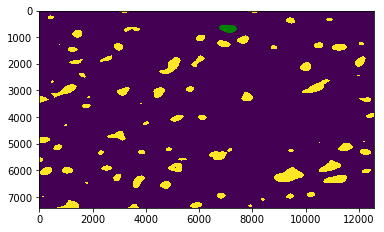

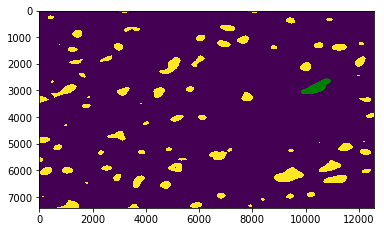

In [6]:
# Sanity check: Plot a plants using their tag id. Here, I have highlighted plants with id=7 and id=30.
plants.plant_show(7)
plants.plant_show(30)

In [7]:
# We can find the distribution of plant size as follows:

# Find area of each plant in pixel
Areas=np.zeros(shape=(1,Num))
for i in range(0,Num):
    Areas[0,i]= plants.plant_area(i)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Normalized distribution (PDF)')

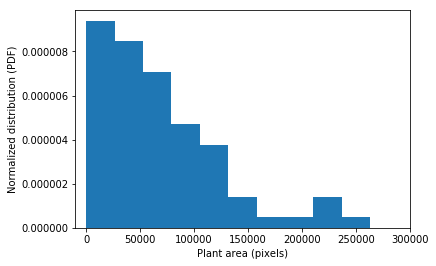

In [8]:
# plot histogram of plant size    
n_bins = 15
#Y=plt.hist(Areas[0,1:], bins=n_bins)
plt.hist(Areas[0,1:], bins=n_bins , normed=1)
plt.xlim([-10000,300000])
plt.xlabel("Plant area (pixels)")
plt.ylabel("Normalized distribution (PDF)")

# Note: This distribution is not accurate due to "edge effect". The area of plants close to the edge of image might be under-estimated.

__Cool Analysis!: Let's find a spatial density function for vegetation:__
Another interesting analysis is to coarse grain the image to find a spatial density function for vegetation. This function could be extremely helpful in doing continuum analysis and finding spatial correlations, scarcity region identification, and other applications. In order to do this, we need a "coarse-graining" density function to pass it to the pixels in the image. An advanced method could be $\exp^{-r/a}$, where $r$ is the radial distance to all central point pixels, and $a$ is the coarse graining parameter (can be chosen arbitrarily). 
However, I have used a simpler method: I find the average number of vegetation pixels within a radius $r$ of each pixel and assign it to the pixel. This algorithm gives a simple basis to visualize a continuum density function. Its accuracy for various applications, however, could be subject to debate.

In [9]:
# These two functions are defined to find and plot the coarse-grained image 
from itertools import product
def points_in_circle(center,radius):
    for x, y in product(range(int(radius) ), repeat=2):
        if (x)**2 + (y)**2 <= radius**2 :
            yield from set(((x+center[0], y+center[1]), (x+center[0], -y+center[1]), (-x+center[0], y+center[1]), (-x+center[0], -y+center[1])))


def coarse_grain(img, radius):
    img2=np.zeros(np.asarray(img.shape))
    for (i, j) in ((x,y) for x in range(0,img.shape[0]) for y in range(0,img.shape[1])):
        points_in_radius = list(points_in_circle([i,j], radius))
        A= np.asarray(points_in_radius)
        B = A[(A[:,0]>0) & (A[:,1]>0) & (A[:,0]<img.shape[0]) & (A[:,1]<img.shape[1])]
        img2[i,j] = np.average(img[B[:,0],B[:,1]])
    return img2       

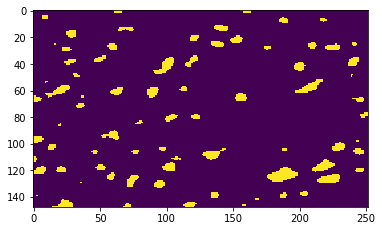

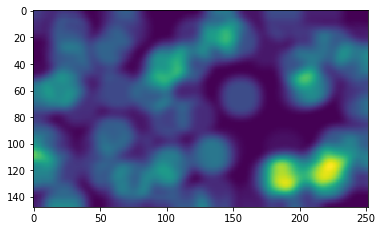

In [11]:
# This part reduces the resolution of image for a faster calculations (less points to pass to the coarse graining filter).
img2=cv2.resize(img, (0,0), fx = 0.02, fy = 0.02)
plt.imshow(img2)
plt.show()

# Here, I passed a two-step filter to visualize the coarse-grained image (radii 15 and 5).
# Depending on the application, any number of filter passing steps could be utilized
img3=coarse_grain(img2,15)   
img_coarse_grained=coarse_grain(img3,5)
plt.imshow(img_coarse_grained)